# Personal Wellness Planner with File I/O


In [83]:
# Core imports
import os
import json
from uuid import uuid4
from typing import Annotated, TypedDict, Literal, Sequence
from dotenv import load_dotenv
import operator

import nest_asyncio
nest_asyncio.apply()  # Required for async operations in Jupyter

# Load OpenAI API Key
load_dotenv("../.env")

True

In [84]:
# Initialize LLMs - GPT-5.2 for supervisors, GPT-4o-mini for specialists
from langchain_openai import ChatOpenAI

# Supervisor model - better reasoning for routing and orchestration
supervisor_llm = ChatOpenAI(model="gpt-5.2", temperature=0)

# Specialist model - cost-effective for domain-specific tasks
specialist_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [85]:
# Import LangGraph and LangChain components
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.agents import create_agent  # LangChain 1.0 API
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, BaseMessage
from langchain_core.tools import tool

In [86]:
# First, let's set up our RAG system for the wellness knowledge base
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

# Load and chunk the wellness document
loader = TextLoader("data/HealthWellnessGuide.txt")
documents = loader.load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100
)
chunks = text_splitter.split_documents(documents)

# Set up vector store
embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")
embedding_dim = len(embedding_model.embed_query("test"))

qdrant_client = QdrantClient(":memory:")
qdrant_client.create_collection(
    collection_name="wellness_multiagent",
    vectors_config=VectorParams(size=embedding_dim, distance=Distance.COSINE)
)

vector_store = QdrantVectorStore(
    client=qdrant_client,
    collection_name="wellness_multiagent",
    embedding=embedding_model
)
vector_store.add_documents(chunks)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})
print(f"Vector store ready with {len(chunks)} documents")

Vector store ready with 45 documents


In [87]:
from typing import Dict, List
from pydantic import BaseModel

class SupervisorIntent(BaseModel):
    """Manages the supervisor's intent decision and parameters necessary for append_plan"""
    intent: Literal["create_plan", "append_plan", "list_plans", "other"]

    # Necesssary for append_plan
    filename: str | None = None
    section: Literal["exercise", "nutrition", "stress"] | None = None
    append_request: str | None = None

    # For debugging
    reasoning: str

class SectionOutput(BaseModel):
    """The output for each section of the wellness plan"""
    section_name: Literal["exercise", "nutrition", "stress"]
    section_content: str

class SupervisorState(TypedDict):
    """State for the supervisor multi-agent system"""
    messages: Annotated[list[BaseMessage], add_messages]

    # For supervisor coordination
    intent: str | None
    filename: str | None
    section: str | None
    append_request: str | None
    reasoning: str | None

    # For deterministic plan creation workflow
    agents_initialized: bool
    remaining_agents: List[str]

    # For routing
    next: str

    # For plan construction
    plan_sections: Dict[str, str]

    final_plan: str

In [88]:
# Create specialized tools for each agent domain
@tool
def search_exercise_info(query: str) -> str:
    """Search for exercise, fitness, and workout information from the wellness knowledge base."""
    results = retriever.invoke(f"exercise fitness workout {query}")
    if not results:
        return "No exercise information found."
    return "\n\n".join([doc.page_content for doc in results])


@tool
def search_nutrition_info(query: str) -> str:
    """Search for nutrition, diet, and healthy eating information from the wellness knowledge base."""
    results = retriever.invoke(f"nutrition diet food meal {query}")
    if not results:
        return "No nutrition information found."
    return "\n\n".join([doc.page_content for doc in results])


@tool
def search_stress_info(query: str) -> str:
    """Search for stress management and mental wellness information from the wellness knowledge base."""
    results = retriever.invoke(f"stress mental wellness mindfulness anxiety {query}")
    if not results:
        return "No stress management information found."
    return "\n\n".join([doc.page_content for doc in results])


exercise_agent = create_agent(
    model=specialist_llm,
    tools=[search_exercise_info],
    response_format=SectionOutput,
    system_prompt=(
        "You are an Exercise Specialist. Always call search_exercise_info before answering. "
        "Return ONLY a JSON object matching SectionOutput (no markdown, no extra text). "
        "Set section_name='exercise'."
    ),
)

nutrition_agent = create_agent(
    model=specialist_llm,
    tools=[search_nutrition_info],
    response_format=SectionOutput,
    system_prompt=(
        "You are a Nutrition Specialist. Always call search_nutrition_info before answering. "
        "Return ONLY a JSON object matching SectionOutput (no markdown, no extra text). "
        "Set section_name='nutrition'."
    ),
)

stress_agent = create_agent(
    model=specialist_llm,
    tools=[search_stress_info],
    response_format=SectionOutput,
    system_prompt=(
        "You are a Stress Management Specialist. Always call search_stress_info before answering. "
        "Return ONLY a JSON object matching SectionOutput (no markdown, no extra text). "
        "Set section_name='stress'."
    ),
)

In [89]:
from langchain_core.prompts import ChatPromptTemplate

supervisor_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a Personal Wellness Planner Supervisor coordinating a team of specialist agents.

Classify the user's request into EXACTLY one intent and extract parameters when present.

Valid intents (must match exactly):
- create_plan: user wants a new wellness plan
- append_plan: user wants to add a section to an existing saved plan
- list_plans: user wants to list saved plans (or available plan files)
- other: anything not related to wellness planning

Extraction rules:
- filename: extract a plan filename if the user provides one; otherwise leave null
- section: for append_plan, extract one of: exercise, nutrition, stress; otherwise leave null
- append_request: for append_plan, extract the user's requested change/content; otherwise leave null

If required info for append_plan is missing, still output intent=append_plan and leave the missing fields null.
Always include a short reasoning string.
""",
        ),
        ("human", "User question: {question}"),
    ]
)

# Create structured output for routing (using GPT-5.2)
routing_llm = supervisor_llm.with_structured_output(SupervisorIntent)


def _last_human_text(messages: list[BaseMessage]) -> str:
    for msg in reversed(messages):
        if isinstance(msg, HumanMessage):
            return msg.content
    return ""

def supervisor_node(state: SupervisorState):
    """Intent detector + workflow coordinator."""

    # Update state via returned dict as LangGraph recommends not mutating state in-place
    updates: dict = {}

    # Detect intent at the start of a user request
    if (not state.get("intent")) or (state.get("next") in ("", None)):
        user_question = _last_human_text(state["messages"])
        prompt_value = supervisor_prompt.invoke({"question": user_question})
        decision: SupervisorIntent = routing_llm.invoke(prompt_value)

        updates.update(
            {
                "intent": decision.intent,
                "filename": decision.filename,
                "section": decision.section,
                "append_request": decision.append_request,
                "reasoning": decision.reasoning,
            }
        )

        # Fresh request => reset deterministic workflow fields
        updates["agents_initialized"] = False
        updates["remaining_agents"] = []

        print(f"[Supervisor]")
        print(f"   intent={decision.intent}")
        print(f"   reasoning={decision.reasoning}")

    # Use latest values (either from initial intent detection or state)
    intent = updates.get("intent", state.get("intent"))

    remaining_agents = list(updates.get("remaining_agents", state.get("remaining_agents", [])))
    agents_initialized = bool(updates.get("agents_initialized", state.get("agents_initialized", False)))

    # print(f"intent: {intent}")
    # print(f"agents_initialized: {agents_initialized}")
    # print(f"remaining_agents: {remaining_agents}")

    if intent == "create_plan":
        # Run all specialist agents in a fixed order once
        if not agents_initialized:
            remaining_agents = ["exercise", "nutrition", "stress"]
            agents_initialized = True

        if remaining_agents:
            next_node = remaining_agents.pop(0)
        else:
            next_node = "plan_builder"
    elif intent == "append_plan" or intent == "list_plans":
        # Assume original request provides filename/section/append_request (not handling edge cases well yet)
        next_node = "file_manager"
    else:
        response_if_unrelated = AIMessage(
            content=f"I am a wellness planner agent. I can help you create a wellness plan, append to an existing plan, or list your saved plans. Please provide a request related to wellness planning.",
        )
        updates["messages"] = [response_if_unrelated]
        next_node = "end"

    updates.update(
        {
            "next": next_node,
            "remaining_agents": remaining_agents,
            "agents_initialized": agents_initialized,
        }
    )

    return updates

In [90]:
def create_agent_node(agent, name: str):
    """Create a node that runs a specialist agent and returns the final response."""
    def agent_node(state: SupervisorState):
        print(f"[{name.upper()} Agent] Processing request...")
        #print(f"messages: {state['messages']}")
        
        # Invoke the specialist agent with the human message
        human_message = _last_human_text(state["messages"])
        result = agent.invoke(HumanMessage(content=human_message))
        #print(f"result: {result}")
        
        # Get the agent's final response
        agent_response = result["structured_response"]
        updated = dict(state.get("plan_sections", {}))
        updated[agent_response.section_name] = agent_response.section_content
        
        # Add agent identifier to the response
        response_with_name = AIMessage(
            content=f"[{name.upper()} SPECIALIST]\n\n{agent_response.section_content}",
            name=name
        )
        
        print(f"[{name.upper()} Agent] Response complete.")
        return {"messages": [response_with_name], "plan_sections": updated}
    
    return agent_node

# Create nodes for each specialist
exercise_node = create_agent_node(exercise_agent, "exercise")
nutrition_node = create_agent_node(nutrition_agent, "nutrition")
stress_node = create_agent_node(stress_agent, "stress")

In [91]:
from langchain_core.prompts import PromptTemplate


def plan_builder_node(state: SupervisorState):
    """Create a node that builds the wellness plan."""
    prompt = PromptTemplate.from_template(
        """
        You are a wellness professional.

        Create a wellness plan based on the user's request, using specialist recommendations where necessary.

        Some rules:
        - The plan should roughly follow the format below (written in markdown).
        - Not all sections or special recommendations are required for every plan.
        - The plan should be tailored to the user's request.
        - The plan should be written in a way that is easy to understand and follow.
        - Don't ask any questions or follow up statements in your response.
        
        Special recommendations:
        {plan_content}

        User Request:
        {user_request}

        Plan Format Template:
        # Personal Wellness Plan: [Some title based on user request]
        Date Generated

        ## Goals

        [Optional Plan Sections]
        ## Exercise Plan
        ## Nutrition Plan
        ## Stress Management Plan

        ## Weekly Check-in
        """
    )
    user_request = _last_human_text(state["messages"])

    plan_sections = state["plan_sections"]
    plan_content = "\n\n".join([f"[{section_name.upper()}]\n\n{section_content}" for section_name, section_content in plan_sections.items()])
    prompt_value = prompt.format(user_request=user_request, plan_content=plan_content)

    print(f"Buliding Wellness Plan...")
    response = supervisor_llm.invoke(prompt_value)
    print(f"Wellness Plan Complete!")

    return {"messages": [AIMessage(content=response.content)], "final_plan": response.content}


In [92]:
from pathlib import Path

# Force the plans directory to exist
PLANS_DIR = Path("plans")
PLANS_DIR.mkdir(parents=True, exist_ok=True)


def _plan_path(filename: str) -> Path:
    # Keep filenames confined to ./plans
    return PLANS_DIR / Path(filename).name

@tool
def save_wellness_plan(filename: str, plan_content: str) -> str:
    """Save the wellness plan to ./plans/<filename>. Returns a confirmation string."""
    path = _plan_path(filename)
    path.write_text(plan_content)
    print(f"Saved plan: {path}")
    return f"Saved plan: {path}"

@tool
def load_wellness_plan(filename: str) -> str:
    """Load a wellness plan from ./plans/<filename> and return its contents."""
    path = _plan_path(filename)
    print(f"Loading plan: {path}")
    return path.read_text()

@tool
def list_saved_plans() -> str:
    """List saved plan files in ./plans."""
    plans = sorted([p.name for p in PLANS_DIR.glob("*.md")])
    if not plans:
        return "No saved plans found in ./plans."
    return "Saved plans:\n" + "\n".join(plans)

@tool
def append_to_plan(filename: str, section: str, content: str):
    """Append to a saved plan."""
    with open(filename, "a") as f:
        f.write(f"\n\n{section.upper()}\n\n{content}")
    print(f"Appended to {filename}")
    return {"messages": [AIMessage(content=f"Appended to {filename}")]}

In [93]:
from datetime import datetime

# LLM for file operations
file_manager_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

file_manager_prompt = """
    You are a file manager for a wellness planning app. 
    Use the provided tools to save/load/list/append plans in the ./plans directory.
    Choose the minimal tool calls needed and then respond with a short user-facing confirmation or the requested content.\n\n
    Rules:\n
    - If intent=create_plan: call save_wellness_plan(filename, plan_content).\n
    - If intent=list_plans: call list_saved_plans().\n
    - If intent=append_plan: call append_to_plan(filename, section, content).
"""

file_manager_agent = create_agent(
    model=file_manager_llm,
    tools=[save_wellness_plan, load_wellness_plan, list_saved_plans, append_to_plan],
    system_prompt=file_manager_prompt,
)

def file_manager_node(state: SupervisorState):
    """Tool-using file manager node."""

    intent = state.get("intent")
    filename = state.get("filename")
    section = state.get("section")
    append_request = state.get("append_request")
    final_plan = state.get("final_plan", "")

    suggested_filename = filename or f"wellness_plan_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.md"

    instruction = (
        f"intent={intent}\n"
        f"filename={filename}\n"
        f"suggested_filename={suggested_filename}\n"
        f"section={section}\n"
        f"append_request={append_request}\n\n"
        f"final_plan_content:\n{final_plan}\n"
    )

    result = file_manager_agent.invoke({"messages": [HumanMessage(content=instruction)]})

    if isinstance(result, dict) and "messages" in result and result["messages"]:
        return {"messages": [result["messages"][-1]]}

    if isinstance(result, dict) and "output" in result:
        return {"messages": [AIMessage(content=str(result["output"]))]}

    return {"messages": [AIMessage(content=str(result))]}
    

In [94]:
def route_to_agent(state: SupervisorState) -> str:
    """Route to the next agent based on supervisor decision."""
    return state["next"]

# Build the main graph
graph = StateGraph(SupervisorState)

graph.add_node("supervisor", supervisor_node)

graph.add_node("exercise", exercise_node)
graph.add_node("nutrition", nutrition_node)
graph.add_node("stress", stress_node)

graph.add_node("plan_builder", plan_builder_node)

graph.add_node("file_manager", file_manager_node)

graph.add_edge(START, "supervisor")

graph.add_conditional_edges(
    "supervisor",
    route_to_agent,
    {
        "exercise": "exercise",
        "nutrition": "nutrition",
        "stress": "stress",
        "plan_builder": "plan_builder",
        "file_manager": "file_manager",
        "end": END,
    },
)

# After each specialist, return to supervisor to decide the next step
graph.add_edge("exercise", "supervisor")
graph.add_edge("nutrition", "supervisor")
graph.add_edge("stress", "supervisor")

# Terminal nodes
graph.add_edge("plan_builder", "file_manager")
graph.add_edge("file_manager", END)

wellness_graph = graph.compile()

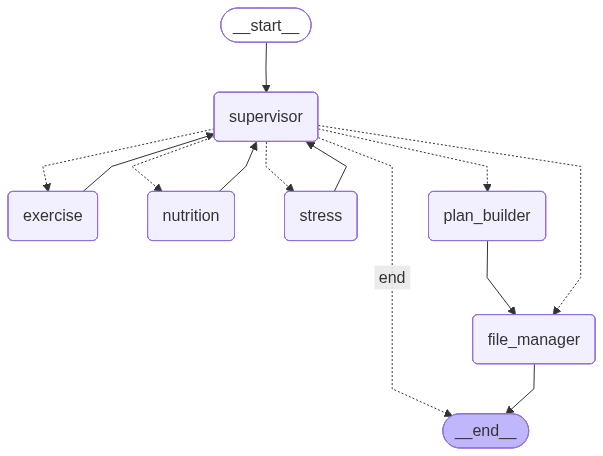

In [95]:
# Display multi-agent graph
from IPython.display import display, Image
display(Image(wellness_graph.get_graph().draw_mermaid_png()))

In [ ]:
# Simple test for wellness graph

# Initialize state first
initial_state: SupervisorState = {
    "messages": [HumanMessage(content="Create me a 7-day beginner wellness plan.")],
    "intent": None,
    "filename": None,
    "section": None,
    "append_request": None,
    "reasoning": None,
    "agents_initialized": False,
    "remaining_agents": [],
    "next": "",
    "plan_sections": {},
    "final_plan": "",
}

output = wellness_graph.invoke(initial_state)
print(output["messages"][-1].content)

[Supervisor]
   intent=create_plan
   reasoning=User explicitly requests a new 7-day beginner wellness plan, which is a new plan creation request.
[EXERCISE Agent] Processing request...
[EXERCISE Agent] Response complete.
[NUTRITION Agent] Processing request...
[NUTRITION Agent] Response complete.
[STRESS Agent] Processing request...
[STRESS Agent] Response complete.
Buliding Wellness Plan...
{'messages': [HumanMessage(content='Create me a 7-day beginner wellness plan.', additional_kwargs={}, response_metadata={}, id='c24b4849-0c59-4419-becf-3d27cf7c74c8'), AIMessage(content='[EXERCISE SPECIALIST]\n\nThe four main types of exercise are aerobic (cardio), strength training, flexibility, and balance exercises. A well-rounded fitness routine includes all four types. Adults should aim for at least 150 minutes of moderate-intensity aerobic activity per week, along with muscle-strengthening activities on 2 or more days per week. Regular physical activity can improve brain health, help manage 

In [ ]:
# Ask for a specific plan focus
initial_state: SupervisorState = {
    "messages": [HumanMessage(content="Create a wellness plan to lose 20 pounds in 6 months.")],
    "intent": None,
    "filename": None,
    "section": None,
    "append_request": None,
    "reasoning": None,
    "agents_initialized": False,
    "remaining_agents": [],
    "next": "",
    "plan_sections": {},
    "final_plan": "",
}

output = wellness_graph.invoke(initial_state)
print(output["messages"][-1].content)

[Supervisor]
   intent=create_plan
   reasoning=User requests a new wellness plan with a specific weight-loss goal (20 pounds) and timeframe (6 months), which fits creating a new plan.
[EXERCISE Agent] Processing request...
[EXERCISE Agent] Response complete.
[NUTRITION Agent] Processing request...
[NUTRITION Agent] Response complete.
[STRESS Agent] Processing request...
[STRESS Agent] Response complete.
Buliding Wellness Plan...
{'messages': [HumanMessage(content='Create a wellness plan to lose 20 pounds in 6 months.', additional_kwargs={}, response_metadata={}, id='6e4b905e-d28a-4a96-ad25-49ad0c13f7ee'), AIMessage(content='[EXERCISE SPECIALIST]\n\nThe four main types of exercise are aerobic (cardio), strength training, flexibility, and balance exercises. A well-rounded fitness routine includes all four types. Adults should aim for at least 150 minutes of moderate-intensity aerobic activity per week, along with muscle-strengthening activities on 2 or more days per week. Regular physic

In [100]:
initial_state: SupervisorState = {
    "messages": [HumanMessage(content="List my saved plans.")],
    "intent": None,
    "filename": None,
    "section": None,
    "append_request": None,
    "reasoning": None,
    "agents_initialized": False,
    "remaining_agents": [],
    "next": "",
    "plan_sections": {},
    "final_plan": "",
}

output = wellness_graph.invoke(initial_state)
print(f"\n")
print(_last_human_text(output["messages"]))
print(output["messages"][-1].content)

[Supervisor]
   intent=list_plans
   reasoning=The user explicitly asked to list their saved plans, which maps to the list_plans intent and includes no filename, section, or append content.


List my saved plans.
Here are the saved wellness plans:

- plan_2026-01-31_11-13-35.md
- plan_2026-01-31_11-19-07.md
- plan_2026-01-31_12-50-02.md
- plan_2026-01-31_12-54-05.md
- plan_2026-01-31_12-55-11.md
- plan_2026-01-31_13-26-22.md
- wellnessplan_2026-01-31_15-03-27.md
- wellnessplan_2026-01-31_15-04-46.md


In [101]:
initial_state: SupervisorState = {
    "messages": [HumanMessage(content="What time is it now?")],
    "intent": None,
    "filename": None,
    "section": None,
    "append_request": None,
    "reasoning": None,
    "agents_initialized": False,
    "remaining_agents": [],
    "next": "",
    "plan_sections": {},
    "final_plan": "",
}

output = wellness_graph.invoke(initial_state)
print(f"\n")
print(_last_human_text(output["messages"]))
print(output["messages"][-1].content)

[Supervisor]
   intent=other
   reasoning=The user is asking for the current time, which is not related to creating, appending, or listing wellness plans.


What time is it now?
I am a wellness planner agent. I can help you create a wellness plan, append to an existing plan, or list your saved plans. Please provide a request related to wellness planning.
